In [27]:
import os
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import ELU, PReLU, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
def build_generator():
    noise_shape = (100,)      
    model = Sequential()
    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()
    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image
    return Model(noise, img)
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)
def train(epochs, batch_size=128, save_interval=50):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3) 
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
        noise = np.random.normal(0, 1, (batch_size, 100)) 
        valid_y = np.array([1] * batch_size) 
        g_loss = combined.train_on_batch(noise, valid_y)
        print("d_loss:", d_loss)

        if epoch % save_interval == 0:
            save_imgs(epoch)
import os

def save_imgs(epoch):

    os.makedirs("images", exist_ok=True)

    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()
optimizer = Adam(0.0002, 0.5) 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
z = Input(shape=(100,)) 
img = generator(z)    
discriminator.trainable = False   
valid = discriminator(img) 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
train(epochs=400, batch_size=32, save_interval=10)
generator.save('generator_model.h5')  


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,493,520 (5.70 MB)

 Trainable params: 1,489,936 (5.68 MB)

 Non-trainable params: 3,584 (14.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
d_loss: [1.2979908 0.203125 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
d_loss: [1.1357698 0.3463542]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
d_loss: [1.1116921 0.3875   ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
d_loss: [1.097321 0.390625]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
d_loss: [1.1003742  0.37430555]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
d_loss: [1.1030146  0.35842803]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
d_loss: [1.1121079  0.34237638]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
d_loss: [1.1161778 0.31875  ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
d_loss: [1.122985   0.29462826]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
d_loss: [1.1315185  0.27886513]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
d_loss: [1.1403782  0.26738366]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
d_loss: [1.1489906 0.2540761]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
d_loss: [1.1554894  0.23658654]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
d_lo

d_loss: [2.642369   0.00828643]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


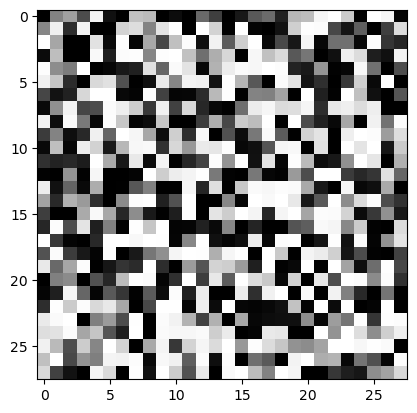

In [28]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn
model = load_model('generator_model.h5')

vector = randn(100)
vector = vector.reshape(1, 100)

X = model.predict(vector)

pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()
